## Step 1: Cleaning the Dataset

First to import all libraries

In [1]:
# <--BASIC & PANDAS: -->
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

# <-- SQL: -->
import sqlite3 
conn = sqlite3.connect('data.db')
cur = conn.cursor()

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn import metrics

import gc; gc.enable()

import warnings
warnings.filterwarnings("ignore")

Cleaning up the dataset. Getting rid of any NaN values and obvious mistakes

In [2]:
pd.options.display.max_columns = 100

In [3]:
df_base = pd.read_csv('kc_house_data.csv')
df_base

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


Checking for all Null values

In [4]:
df_base.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

## Waterfront Clean up
Waterfront data is conditional. So we should replace the NaNs with the most common category. So, it should be replaced with 0's as "false".

In [5]:
df_base.waterfront.fillna(value=0,inplace=True)

In [6]:
df_base.waterfront.value_counts()

0.0    21451
1.0      146
Name: waterfront, dtype: int64

## View Clean up

View Nulls will be just dropped

In [7]:
df_base.dropna(subset=['view'],inplace=True)

## Year Renovated Clean up

We are changing out any nulls in the yr_renovated to 0s

In [8]:
df_base.yr_renovated.fillna(value=0,inplace=True)

## Convert sqft_basement to int64 from object

The sqft_basement column has random "?"s so we will properly calculate those and change the values into floats

In [9]:
df_base.loc[df_base.sqft_basement == '?']

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,3,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
18,16000397,12/5/2014,189000.0,2,1.00,1200,9850,1.0,0.0,0.0,4,7,1200,?,1921,0.0,98002,47.3089,-122.210,1060,5095
42,7203220400,7/7/2014,861990.0,5,2.75,3595,5639,2.0,0.0,0.0,3,9,3595,?,2014,0.0,98053,47.6848,-122.016,3625,5639
79,1531000030,3/23/2015,720000.0,4,2.50,3450,39683,2.0,0.0,0.0,3,10,3450,?,2002,0.0,98010,47.3420,-122.025,3350,39750
112,2525310310,9/16/2014,272500.0,3,1.75,1540,12600,1.0,0.0,0.0,4,7,1160,?,1980,0.0,98038,47.3624,-122.031,1540,11656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21442,3226049565,7/11/2014,504600.0,5,3.00,2360,5000,1.0,0.0,0.0,3,7,1390,?,2008,0.0,98103,47.6931,-122.330,2180,5009
21447,1760650900,7/21/2014,337500.0,4,2.50,2330,4907,2.0,0.0,0.0,3,7,2330,?,2013,0.0,98042,47.3590,-122.081,2300,3836
21473,6021503707,1/20/2015,352500.0,2,2.50,980,1010,3.0,0.0,0.0,3,8,980,?,2008,0.0,98117,47.6844,-122.387,980,1023
21519,2909310100,10/15/2014,332000.0,4,2.50,2380,5737,2.0,0.0,0.0,3,7,2380,?,2010,0.0,98023,47.2815,-122.356,2380,5396


In [10]:
df_base.sqft_basement.replace(to_replace = '?', value = df_base.sqft_living - df_base.sqft_above, inplace=True)

In [11]:
df_base.sqft_basement = df_base.sqft_basement.astype("float32")

Double Checking if the null values have been cleaned up

In [12]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21534 entries, 0 to 21596
Data columns (total 21 columns):
id               21534 non-null int64
date             21534 non-null object
price            21534 non-null float64
bedrooms         21534 non-null int64
bathrooms        21534 non-null float64
sqft_living      21534 non-null int64
sqft_lot         21534 non-null int64
floors           21534 non-null float64
waterfront       21534 non-null float64
view             21534 non-null float64
condition        21534 non-null int64
grade            21534 non-null int64
sqft_above       21534 non-null int64
sqft_basement    21534 non-null float32
yr_built         21534 non-null int64
yr_renovated     21534 non-null float64
zipcode          21534 non-null int64
lat              21534 non-null float64
long             21534 non-null float64
sqft_living15    21534 non-null int64
sqft_lot15       21534 non-null int64
dtypes: float32(1), float64(8), int64(11), object(1)
memory usage: 4.2+ MB

Now to get rid of any obvious data that needs to be cleaned out

Looks like theres a wierd outlier in the bedroom counts so we'll change that to something that seems more realistic

In [13]:
df_base.bedrooms.value_counts()

3     9791
4     6865
2     2754
5     1596
6      270
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [14]:
df_base['bedrooms'].replace(to_replace = 33, value =3 , inplace=True)

## Baseline Modeling

Let's take a quick look at the data and see how it is at a quick glance

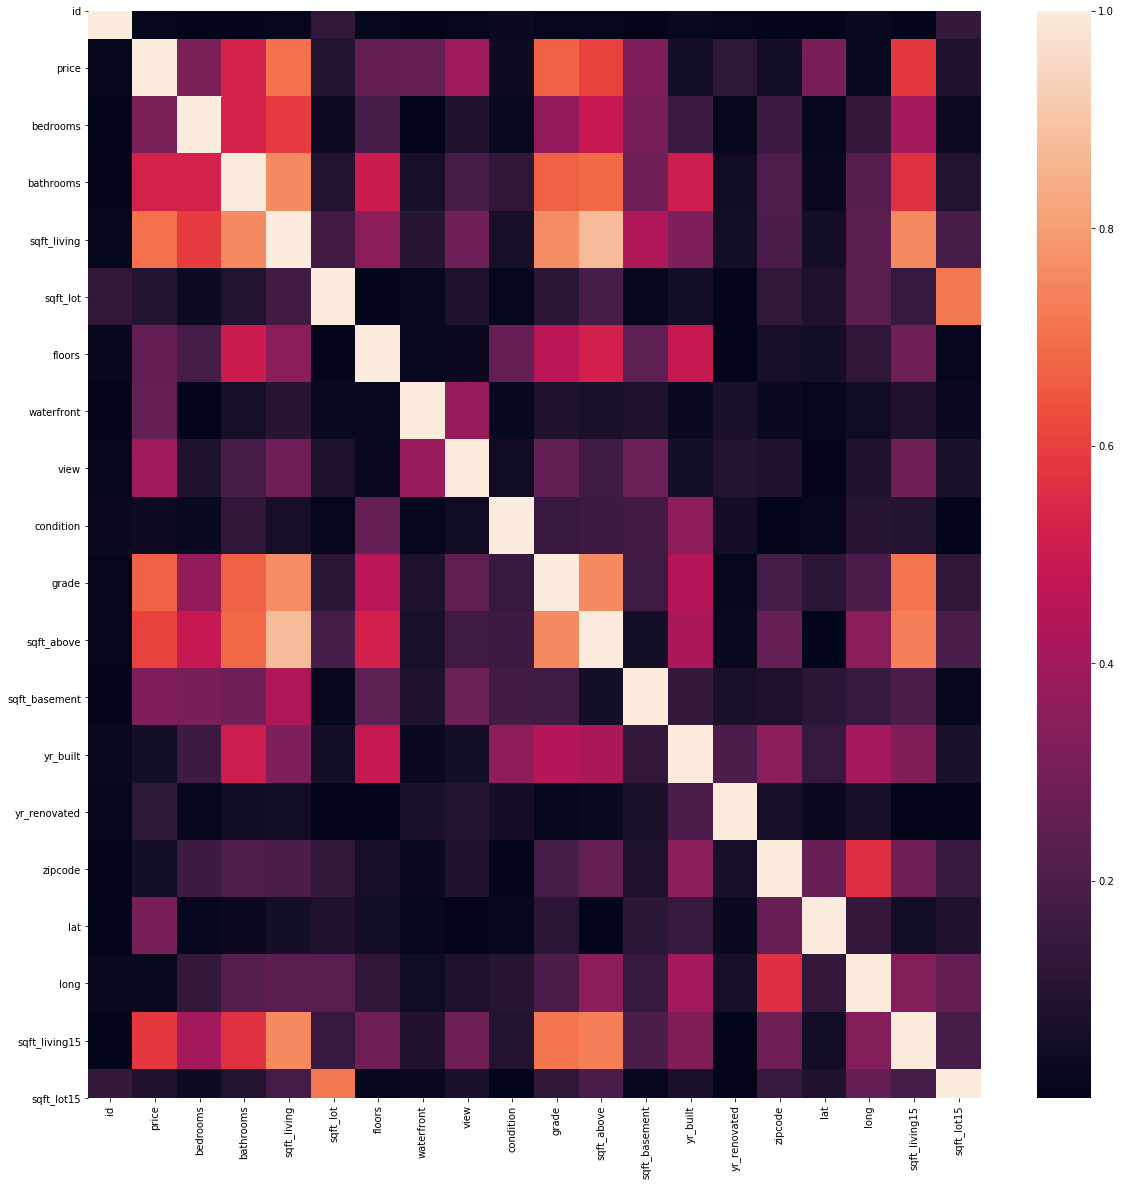

In [15]:
plt.figure(figsize = (20,20))
sns.heatmap(df_base.corr().abs())

## Most important columns
Correlation Target = Price
* Bedrooms & Bathrooms
* Sq footage living/living 15
* Sq footage above/basement
* grade
* zip, lat long

## Columns with little impact
* Date
* yr built / yr renovated
* condition
* waterfront

We've decided to drop the date column since objects don't translate too nicely with modeling

In [16]:
df_edit = df_base.drop(columns=['date'])

In [17]:
def cv_results (df):
    target = "price"
    used_cols = [c for c in df.columns.to_list() if c not in [target]]

    X = df[used_cols]
    y = df[target]
    
    scaler = RobustScaler()
    lr = LinearRegression()
    pipe = make_pipeline(scaler, lr)

    metrics = ['r2', 'neg_mean_squared_error']
    
    cv = cross_validate(pipe, X, y, cv=3, n_jobs=-1, scoring=metrics,return_train_score=True)
    return cv

In [18]:
cv_base = cv_results(df_edit)

In [19]:
cv_base

{'fit_time': array([0.04141474, 0.04232812, 0.04188085]),
 'score_time': array([0.00467205, 0.00453305, 0.00511694]),
 'test_r2': array([0.69825846, 0.69247075, 0.69575986]),
 'train_r2': array([0.70065807, 0.70398594, 0.69970625]),
 'test_neg_mean_squared_error': array([-4.13376855e+10, -4.02826672e+10, -4.06551676e+10]),
 'train_neg_mean_squared_error': array([-3.96562794e+10, -4.00822592e+10, -4.02404870e+10])}

In [20]:
cv_base['test_r2'].mean()

0.6954963579543829

In [21]:
cv_base['train_r2'].mean()

0.7014500841259427

## Further Model Manipulation

Running the cross validation model again with just the columns that had higher correlations with the target

In [22]:
df_test1 = df_edit[['price','bedrooms','bathrooms','sqft_living','floors', 'waterfront', 'view','grade', 'sqft_above','zipcode', 'lat', 'long',
       'sqft_living15']]

In [23]:
cv_test1 = cv_results(df_test1)

In [24]:
cv_test1

{'fit_time': array([0.01708984, 0.01538706, 0.01635885]),
 'score_time': array([0.00295138, 0.00392294, 0.00287628]),
 'test_r2': array([0.66513881, 0.65805583, 0.6776664 ]),
 'train_r2': array([0.67141205, 0.67511818, 0.66436149]),
 'test_neg_mean_squared_error': array([-4.58749772e+10, -4.47906127e+10, -4.30729705e+10]),
 'train_neg_mean_squared_error': array([-4.35307387e+10, -4.39911440e+10, -4.49768165e+10])}

In [25]:
cv_test1['test_r2'].mean()

0.6669536804146082

In [26]:
cv_test1['train_r2'].mean()

0.670297242047134

## Manipulation Test 2

In [27]:
df_test2 = df_edit

In [28]:
target = "price"
used_cols = [c for c in df_test2.columns.to_list() if c not in [target]]

X = df_test2[used_cols]
y = df_test2[target]

X['bedroom squared'] = X['bedrooms']**2
X['grade'] = X['grade']**2
X['living area squared'] = X['sqft_living']**2

scaler = RobustScaler()
lr = LinearRegression()
pipe1 = make_pipeline(scaler, lr)

scores = cross_val_score(pipe1, X, y, cv=5, scoring='neg_mean_squared_error')
print("RMSE:", -scores.mean(), "+/-", scores.std())

scores = cross_val_score(pipe1, X, y, cv=5, scoring='r2')
print("R^2:", scores.mean(), "+/-", scores.std())

RMSE: 36565321676.604416 +/- 2166315353.0767293
R^2: 0.7249965876540311 +/- 0.02698142168970184


In [29]:
target = "price"
used_cols = [c for c in df_test2.columns.to_list() if c not in [target]]

X = df_test2[used_cols]
y = df_test2[target]

X['lat_long squared and added'] = X['lat']+ X['long']
X['sqft above and basement squared and added'] = X['sqft_above']+ X['sqft_basement']**2
X['sqft neighbors squared and added'] = X['sqft_living15']+ X['sqft_lot15']**2

scaler = RobustScaler()
lr = LinearRegression()
pipe1 = make_pipeline(scaler, lr)

scores = cross_val_score(pipe1, X, y, cv=5, scoring='neg_mean_squared_error')
print("RMSE:", -scores.mean(), "+/-", scores.std())

scores = cross_val_score(pipe1, X, y, cv=5, scoring='r2')
print("R^2:", scores.mean(), "+/-", scores.std())

RMSE: 40673442631.80516 +/- 3236560430.5083632
R^2: 0.6957325620404605 +/- 0.012326126958593786


In [30]:
df_test2

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


* Baseline:
    * RMSE: 40706120003.98163 +/- 3519130597.389371
    * R^2: 0.6958027871012469 +/- 0.008558753537769092
        
        
* Squared Bedroom, Grade and Living Area:
    * RMSE: 36565321676.604416 +/- 2166315353.0767293
    * R^2: 0.7249965876540311 +/- 0.02698142168970184


Plotting GAM Models

In [31]:
df1 = df_base[df_base['sqft_living'] < 8000] # we do not want to change our raw dataframe so assigning new one.

In [32]:
df_zipcodes = df1.copy()

In [33]:
df_medina = df_zipcodes.loc[df_zipcodes['zipcode']==98039] # create dataframe for Medina city

In [34]:
target = 'price'
used_cols = [c for c in df_medina.columns.to_list() if c not in [target]]
# create our X and y values
X_medina = df_medina[used_cols]
y_medina = df_medina[target]

In [35]:
from pygam import LinearGAM
from pygam import GAM

gam = GAM(distribution='gamma', link='log')
gam.gridsearch(X_medina.values, y_medina.values)
gam.summary()

ValueError: unknown special directive

In [ ]:
## plotting GAM Medina
N = len(X_medina)
fig, axs = plt.subplots(1,N,figsize=(N*5,5))

titles = used_cols
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
fig.tight_layout()
fig.show()

IF you choose whatever zip code we can give you a certain %
turn df_zip_results into bar plot


In [36]:
df_zip_results = pd.DataFrame(columns=['zipcode',"Model", "Info",'Pseudo R^2'])

In [37]:
df_zip_results = df_zip_results.append({       # keeping the results in df
     "zipcode": '98039' ,
      "Model": 'LinearGAM',
       'Info' : 'n_splines=25' ,
        'Pseudo R^2' : '0.9999'}, ignore_index=True)

In [38]:
df_zip_results = df_zip_results.append({       # keeping the results in df
     "zipcode": '98004' ,
      "Model": 'LinearGAM',
       'Info' : 'n_splines=100' ,
        'Pseudo R^2' : '0.9998'}, ignore_index=True)

In [39]:
df_zip_results = df_zip_results.append({       # keeping the results in df
     "zipcode": '98040' ,
      "Model": 'GAM with gamma distribution',
       'Info' : 'Loglink Function' ,
        'Pseudo R^2' : '0.9117'}, ignore_index=True)

In [40]:
df_zip_results = df_zip_results.append({       # keeping the results in df
     "zipcode": '98103' ,
      "Model": 'LinearGAM',
       'Info' : '80 splines' ,
        'Pseudo R^2' : '0.9945'}, ignore_index=True)

In [41]:

df_zip_results = df_zip_results.append({       # keeping the results in df
     "zipcode": '98038' ,
      "Model": 'LinearGAM',
       'Info' : 'with long-lat tensor' ,
        'Pseudo R^2' : '0.9635'}, ignore_index=True)

In [42]:
df_zip_results.insert(1, "City Names", ['Medina', 'Bellevue', 'Mercer Island', 'Seattle','Maple Valley'], True)

In [43]:
df_zip_results

,zipcode,City Names,Model,Info,Pseudo R^2
0,98039,Medina,LinearGAM,n_splines=25,0.9999
1,98004,Bellevue,LinearGAM,n_splines=100,0.9998
2,98040,Mercer Island,GAM with gamma distribution,Loglink Function,0.9117
3,98103,Seattle,LinearGAM,80 splines,0.9945
4,98038,Maple Valley,LinearGAM,with long-lat tensor,0.9635


In [44]:
df_zip_results['Pseudo R^2'] = df_zip_results['Pseudo R^2'].astype("float32")

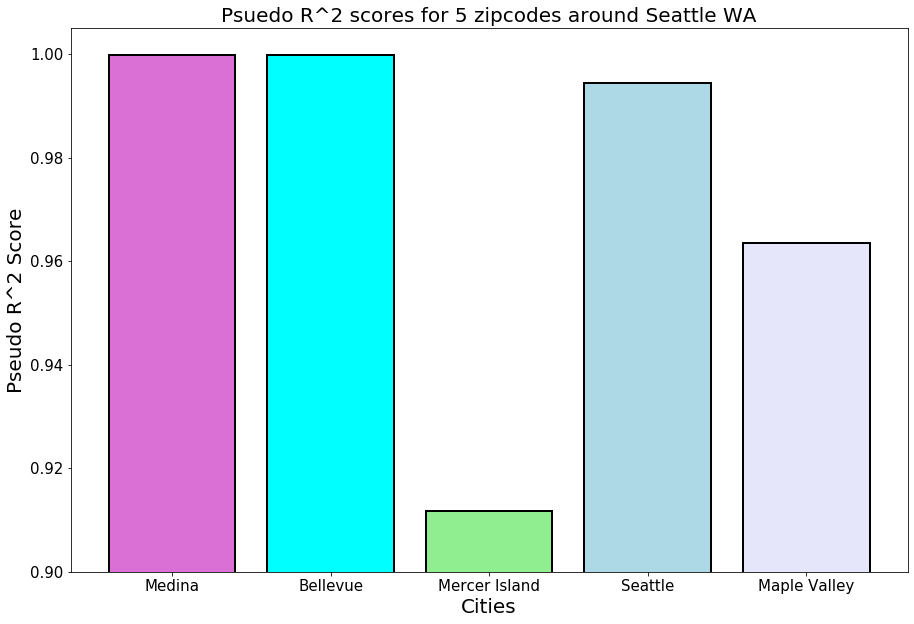

In [45]:
x = df_zip_results['City Names']
y = df_zip_results['Pseudo R^2']

plt.figure(figsize=((15,10)))
y_pos = np.arange(len(y))
x_pos = np.arange(len(x))

plt.bar(x,y, width=0.8, align='center') 
plt.bar(y_pos, y,color=['orchid','aqua','lightgreen','lightblue','lavender'],edgecolor='black',linewidth=2)

plt.ylim(bottom=0.9)
plt.ylim(top=1.005)
plt.ylabel('Pseudo R^2 Score', fontsize=20)
plt.xlabel('Cities',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(x_pos, x,fontsize=15)
plt.title('Psuedo R^2 scores for 5 zipcodes around Seattle WA', fontsize=20)

plt.show()